In [1]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df = train_df[["text", "target"]]
train_df["text"] = train_df["text"].astype("str")
# test_df = test_df[["text"]]
# test_df = test_df.astype("str")

In [5]:
train_df[train_df.target == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [6]:
print(f"shape of train data: {train_df.shape}\nshape of test data: {test_df.shape}")

shape of train data: (7613, 2)
shape of test data: (3263, 4)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [12,8]

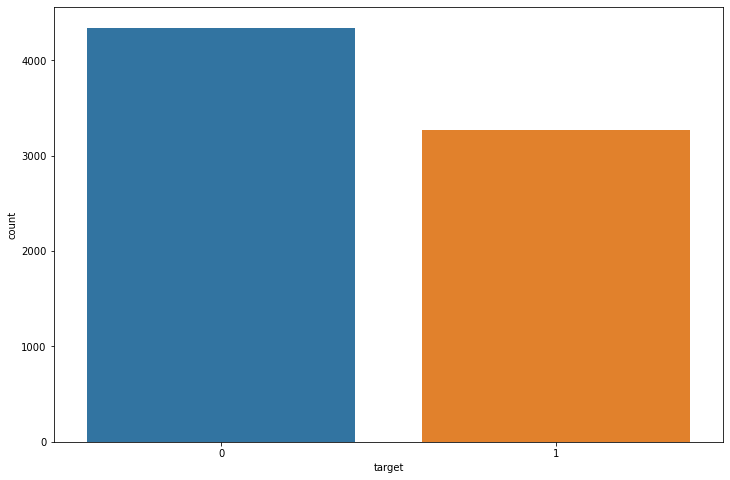

In [8]:
sns.countplot("target", data=train_df)
plt.show()

In [9]:
train_df.groupby(by=["target"]).text.count()

target
0    4342
1    3271
Name: text, dtype: int64

In [10]:
def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    print(tweet_blob.words)
    return ' '.join(tweet_blob.words)

def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

In [11]:
form_sentence(train_df["text"].iloc[10])

['Three', 'people', 'died', 'from', 'the', 'heat', 'wave', 'so', 'far']


'Three people died from the heat wave so far'

In [12]:
def text_processing(tweet):
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [13]:
train_df["target_list"] = train_df["text"].apply(text_processing)
test_df["target_list"] = test_df["text"].apply(text_processing)

In [16]:
train_df[train_df.target == 1]

,text,target,target_list
0,Our Deeds are the Reason of this #earthquake M...,1,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,All residents asked to 'shelter in place' are ...,1,"[residents, ask, place, notify, officer, evacu..."
3,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,Just got sent this photo from Ruby #Alaska as ...,1,"[get, send, photo, Ruby, Alaska, smoke, wildfi..."
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,"[Two, giant, crane, hold, bridge, collapse, ne..."
7609,@aria_ahrary @TheTawniest The out of control w...,1,"[aria_ahrary, TheTawniest, control, wild, fire..."
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[UTC, Volcano, Hawaii, http]"
7611,Police investigating after an e-bike collided ...,1,"[Police, investigate, collide, car, Little, Po..."


In [17]:
# Using Naive Bayes Classifier
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [18]:
msg_train, msg_test, label_train, label_test = train_test_split(train_df['text'], train_df['target'], test_size=0.2)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1014
           1       0.62      0.80      0.70       509

    accuracy                           0.77      1523
   macro avg       0.75      0.78      0.76      1523
weighted avg       0.80      0.77      0.78      1523

[[769 245]
 [103 406]]
0.7715036112934996


In [19]:
predictions = pipeline.predict(test_df["text"])

In [20]:
test_df["target"] = predictions

In [22]:
test_df[test_df.target == 0]

,id,keyword,location,text,target_list,target
6,21,NaN,NaN,They'd probably still show more life than Arse...,"[probably, still, show, life, Arsenal, yesterd...",0
7,22,NaN,NaN,Hey! How are you?,[Hey],0
8,27,NaN,NaN,What a nice hat?,"[nice, hat]",0
9,29,NaN,NaN,Fuck off!,[Fuck],0
10,30,NaN,NaN,No I don't like cold!,"[like, cold]",0
...,...,...,...,...,...,...
3249,10816,wrecked,los angeles,@thrillhho jsyk I haven't stopped thinking abt...,"[thrillhho, jsyk, stop, think, abt, remus, slu...",0
3250,10820,wrecked,"Brussels, Belgium",@stighefootball Begovic has been garbage. He g...,"[stighefootball, Begovic, garbage, get, wreck,...",0
3251,10828,wrecked,NaN,Wrecked today got my hattrick ????,"[Wrecked, today, get, hattrick]",0
3256,10857,NaN,NaN,To conference attendees! The blue line from th...,"[conference, attendees, blue, line, airport, D...",0


In [ ]:
test_df[test_df.target == 1]

In [14]:
# to_save.to_csv("pranit_nlp_submission.csv", index=False, header=True)

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [25]:
msg_train, msg_test, label_train, label_test = train_test_split(train_df['text'], train_df['target'], test_size=0.2)
sgd_pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       944
           1       0.83      0.94      0.88       579

    accuracy                           0.90      1523
   macro avg       0.89      0.91      0.90      1523
weighted avg       0.91      0.90      0.90      1523

[[829 115]
 [ 35 544]]
0.9015101772816809


In [26]:
sgd_predictions = sgd_pipeline.predict(test_df["text"])

In [27]:
test_df["target"] = sgd_predictions

In [29]:
test_df.groupby(by = ["target"]).id.count()

target
0    2558
1     705
Name: id, dtype: int64

In [30]:
sgd_save = test_df[["id", "target"]]
sgd_save.to_csv("pranit_submission2.csv", index = False, header = True)

In [38]:
test_df[test_df.target == 0].head(20)

,id,keyword,location,text,target_list,target
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","[Heard, earthquake, different, cities, stay, s...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[Apocalypse, light, Spokane, wildfires]",0
5,12,NaN,NaN,We're shaking...It's an earthquake,"[shake, earthquake]",0
6,21,NaN,NaN,They'd probably still show more life than Arse...,"[probably, still, show, life, Arsenal, yesterd...",0
7,22,NaN,NaN,Hey! How are you?,[Hey],0
8,27,NaN,NaN,What a nice hat?,"[nice, hat]",0
9,29,NaN,NaN,Fuck off!,[Fuck],0
10,30,NaN,NaN,No I don't like cold!,"[like, cold]",0
11,35,NaN,NaN,NOOOOOOOOO! Don't do that!,[NOOOOOOOOO],0
12,42,NaN,NaN,No don't tell me that!,[tell],0
